In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensions
input_dim = 768
output_dim = 768
rank_r = 4  # very low rank compared to input/output dims

# Original weight matrix
W = np.random.randn(output_dim, input_dim)

# LoRA matrices (initial state randomized. Not derived from W)
A = np.random.randn(output_dim, rank_r)
B = np.random.randn(rank_r, input_dim)

# Input vector
x = np.random.randn(input_dim, 1)

# Original output
y_orig = W @ x

# LoRA update output
delta_y = A @ (B @ x)

# Total output with LoRA
y_lora = y_orig + delta_y

# Step 3: Compute low-rank update
delta_W = A @ B

print("Original params:", W.size)
print("LoRA params:", A.size + B.size)
print(f"Parameter reduction factor: {W.size / (A.size + B.size):.2f}x")

# Visualize shapes
fig, ax = plt.subplots(1, 5, figsize=(24,4))

ax[0].imshow(W, aspect='auto', cmap='viridis')
ax[0].set_title("Original weight W (Frozen)\n(shape {})".format(W.shape))

#ax[1].set_aspect(768 / 4)  # width / height
ax[1] = fig.add_axes([0.3, 0.35, 0.1, 0.06])  # left, bottom, width, height
ax[1].imshow(B, aspect='auto', cmap='plasma')
ax[1].set_title("LoRA matrix B\n(shape {})".format(B.shape))

#ax[2].set_aspect(4 / 768)
ax[2] = fig.add_axes([0.5, 0.15, 0.01, 0.6])  # left, bottom, width, height
ax[2].imshow(A, aspect='auto', cmap='plasma')
ax[2].set_title("LoRA matrix A\n(shape {})".format(A.shape))

ax[3].imshow(delta_W, aspect='auto', cmap='plasma')
ax[3].set_title("LoRA ΔW = A @ B \n (low-rank update)")

ax[4].imshow(W + delta_W, aspect='auto', cmap='coolwarm')
ax[4].set_title("Adapted W + ΔW \n (final effective weights)")

plt.show()


In [ ]:
# Quantization: It uses a notebook to round the weights
# This notebook is derived of the bell shaped (Guassian distribution) of all weights in the model
# Weights in models are initialized using Gaussian distribution and trainign does not alter them substantially


# Simulate a normally-distributed weight matrix (like in transformers)
weights = np.random.normal(loc=0, scale=0.5, size=10000)

# Clip to [-1, 1] for NF4 range
clipped = np.clip(weights, -1, 1)

# NF4 codebook (used in QLoRA) 16 bit (original precission) codebook grouped near 0 (not evenly distributed)
codebook = np.array([
    -1.0, -0.696, -0.522, -0.394,
    -0.284, -0.184, -0.097, -0.02,
     0.02,  0.097,  0.184,  0.284,
     0.394, 0.522, 0.696, 1.0
])

# Quantize: find nearest codebook value for each weight
quantized_indices = np.argmin(np.abs(clipped[:, None] - codebook[None, :]), axis=1)
quantized_values = codebook[quantized_indices]

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].hist(clipped, bins=50, color='skyblue', alpha=0.7, label='Original Weights')
axs[0].set_title("Original Clipped Weights (Float32)")
axs[0].legend()

axs[1].hist(codebook, bins=16, color='orange', alpha=0.7, label='Quantized (NF4)')
axs[1].set_title("Round codebook")
axs[1].legend()

axs[2].hist(quantized_values, bins=16, color='orange', alpha=0.7, label='Quantized (NF4)')
axs[2].set_title("Quantized Weights: \nOriginal + codebook(NF4, 4-bit)")
axs[2].legend()

plt.suptitle("QLoRA Quantization: Float32 vs NF4 (4-bit Approximation)", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
even_distribution = np.linspace(-1, 1, 16)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(even_distribution, bins=16, color='skyblue', alpha=0.7, label='Linspace codebook')
axs[0].set_title("Evenly distributed codebook")
axs[0].legend()

axs[1].hist(codebook, bins=16, color='orange', alpha=0.7, label='Quantized codebook (NF4)')
axs[1].set_title("NF4 Round codebook")
axs[1].legend()

In [ ]:
# In nVIDIA GPUs the LoRA adapters that can't be stored in the GPU are offloaded to the CPU (paged optimized)



 y_orig

    Meaning: The original output from the frozen weights.

    Formula: y_orig = W @ x

    Interpretation: What the base model would output without any fine-tuning.

🔼 delta_y (aka Δy or ΔW @ x)

    Meaning: The LoRA-added adjustment to the output.

    Formula: delta_y = B @ (A @ x)

    Interpretation: The additional signal from the low-rank adapters. This is what is being fine-tuned during LoRA training.

🧮 y_lora

    Meaning: The final output of the LoRA-adapted model.

    Formula: y_lora = y_orig + delta_y = W @ x + B @ (A @ x)

    Interpretation: What is actually passed forward through the model after LoRA is applied.

    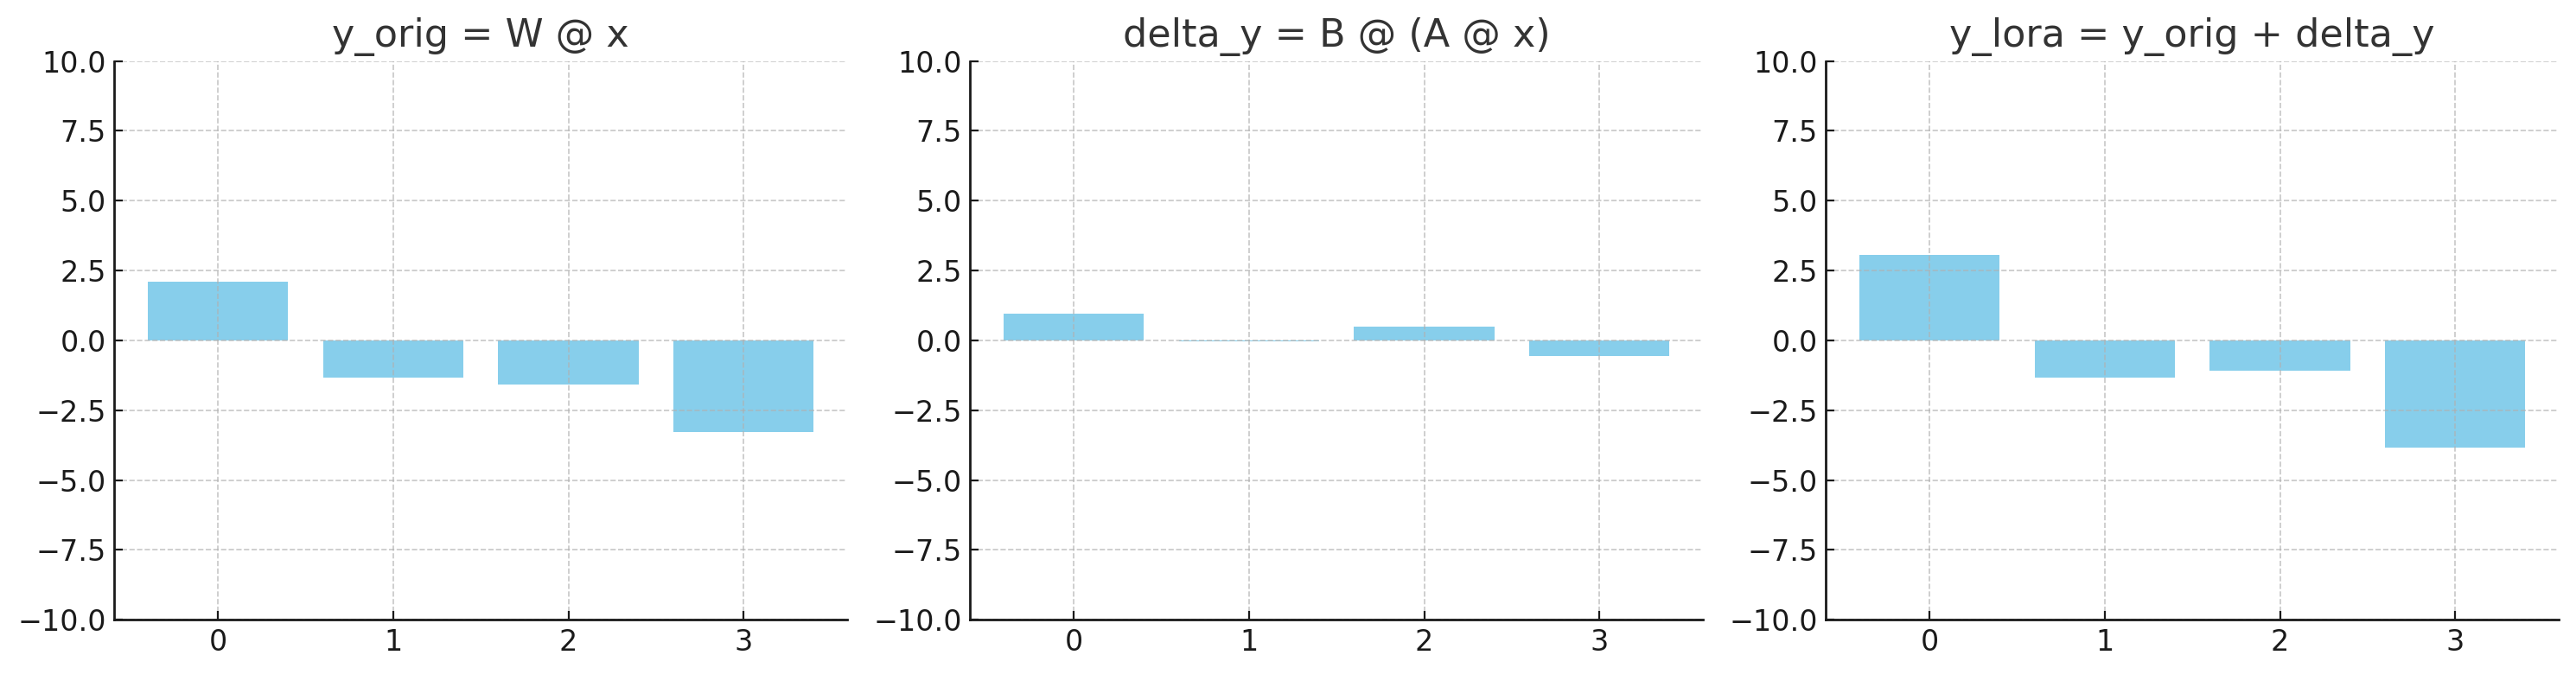

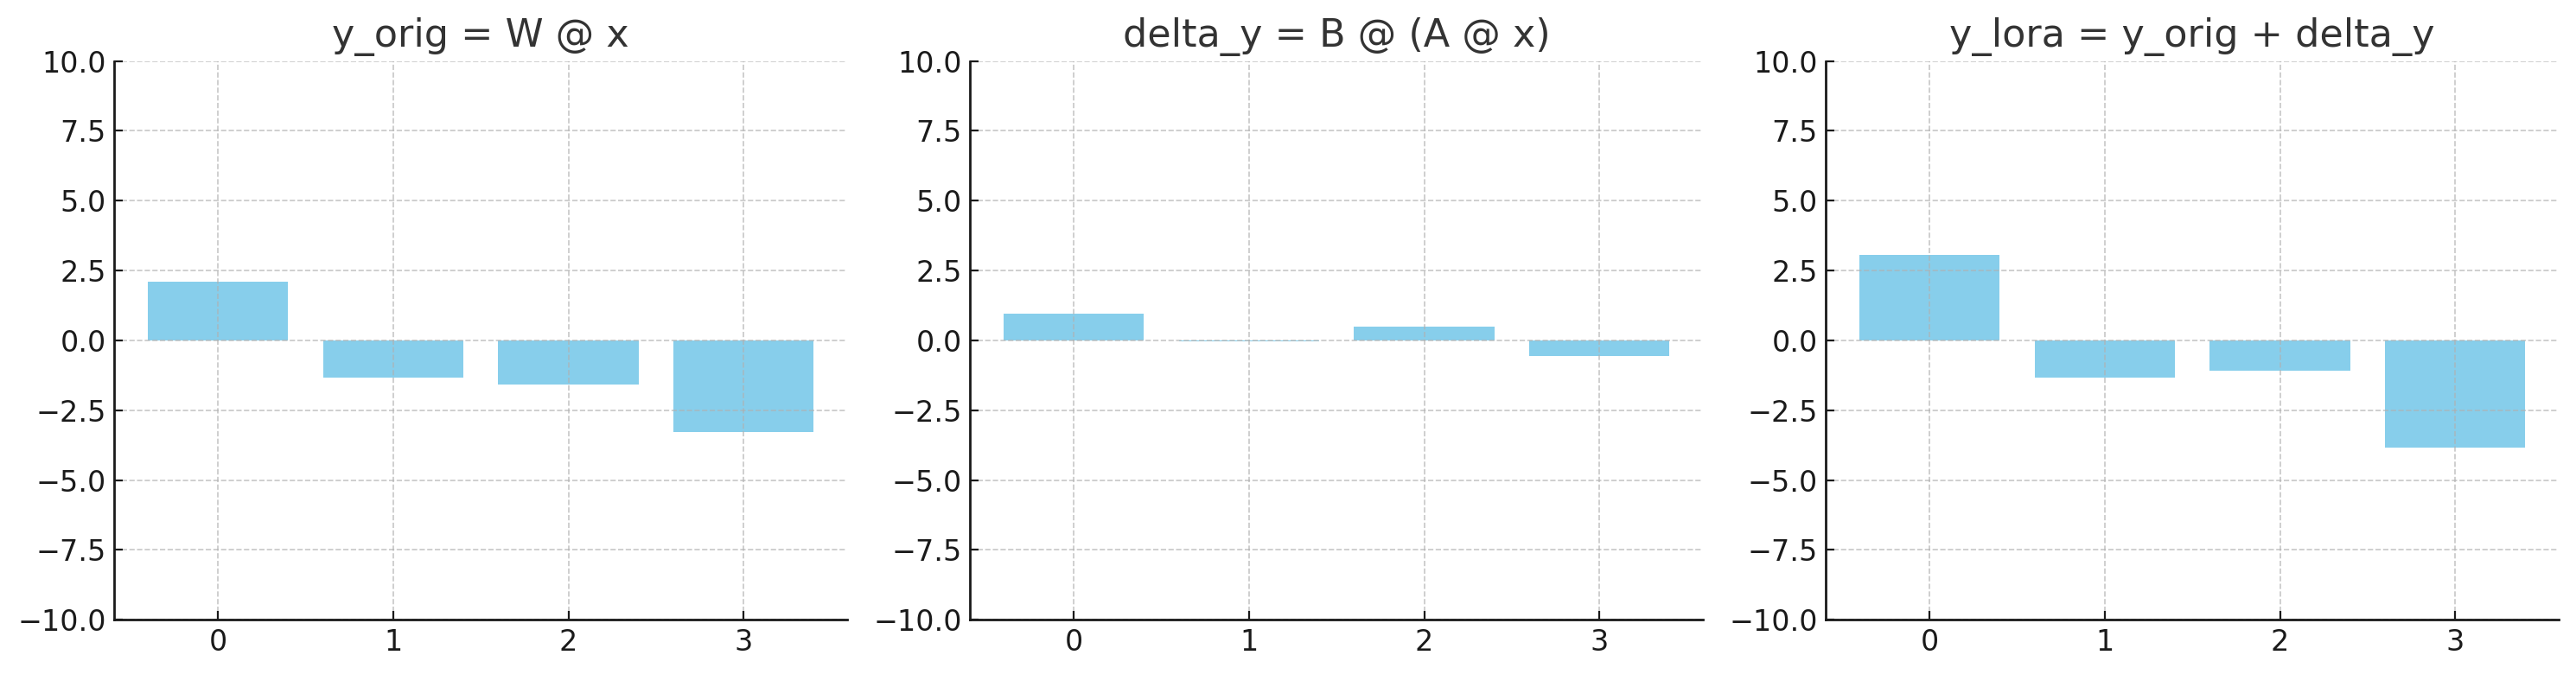